# Predicting Scope 3 Emissions
### XGBoost and Random Forest Machine Learning Models
##### (*Post-Outlier Removal and Post-Skew Transformation*)

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import math
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [3]:
# Load final csv file into a DataFrame
df = pd.read_csv('Final_GHG_Data.csv')
df.head()

account_name  account_id  Year incorporated_country Primary activity  \
0     3i Group          44  2018       United Kingdom   Asset managers   
1     3i Group          44  2018       United Kingdom   Asset managers   
2     3i Group          44  2018       United Kingdom   Asset managers   
3     3i Group          44  2018       United Kingdom   Asset managers   
4     3i Group          44  2018       United Kingdom   Asset managers   

       Primary sector  Market_Cap_USD  \
0  Financial services    9.548124e+09   
1  Financial services    9.548124e+09   
2  Financial services    9.548124e+09   
3  Financial services    9.548124e+09   
4  Financial services    9.548124e+09   

                            Third_party_verification   Revenue_USD  \
0  Third-party verification or assurance process ...  1.728470e+09   
1  Third-party verification or assurance process ...  1.728470e+09   
2  Third-party verification or assurance process ...  1.728470e+09   
3  Third-party verification or assurance process ...  1.728470e+09   
4  Third-party verification or assurance process ...  1.728470e+09   

     ebitda_USD  ...  totalInvestments_USD  totalDebt_USD  totalEquity_USD  \
0  1.565910e+09  ...          8.544560e+09    730250000.0     1.004443e+10   
1  1.565910e+09  ...          8.544560e+09    730250000.0     1.004443e+10   
2  1.565910e+09  ...          8.544560e+09    730250000.0     1.004443e+10   
3  1.565910e+09  ...          8.544560e+09    730250000.0     1.004443e+10   
4  1.565910e+09  ...          8.544560e+09    730250000.0     1.004443e+10   

                              Scope_3_emissions_type  \
0                       Purchased goods and services   
1  Fuel-and-energy-related activities (not includ...   
2                      Waste generated in operations   
3                                    Business travel   
4                                 Employee commuting   

   Scope_3_emissions_amount  country_ghg_avg  country_population_avg  \
0                     17.62       428.766726            6.734692e+07   
1                     61.42       428.766726            6.734692e+07   
2                     57.21       428.766726            6.734692e+07   
3                   2549.33       428.766726            6.734692e+07   
4                      3.90       428.766726            6.734692e+07   

   country_gdp_avg  Quantile_Market_Cap_USD  BoxCox_Market_Cap_USD  
0     3.038320e+12                 0.105759              18.477048  
1     3.038320e+12                 0.105759              18.477048  
2     3.038320e+12                 0.105759              18.477048  
3     3.038320e+12                 0.105759              18.477048  
4     3.038320e+12                 0.105759              18.477048  

[5 rows x 27 columns]

In [6]:
df.columns.unique()

Index(['account_name', 'account_id', 'Year', 'incorporated_country',
       'Primary activity', 'Primary sector', 'Market_Cap_USD',
       'Third_party_verification', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_type',
       'Scope_3_emissions_amount', 'country_ghg_avg', 'country_population_avg',
       'country_gdp_avg', 'Quantile_Market_Cap_USD', 'BoxCox_Market_Cap_USD'],
      dtype='object')

## Correlation Analysis
Check for correlation on each numerical feature to Scope 3 emissions amount.

Because the machine learning model will need to predict by Emission type, I will attempt plot the average correlation for each emission type.

#### *Correlation Heatmap*

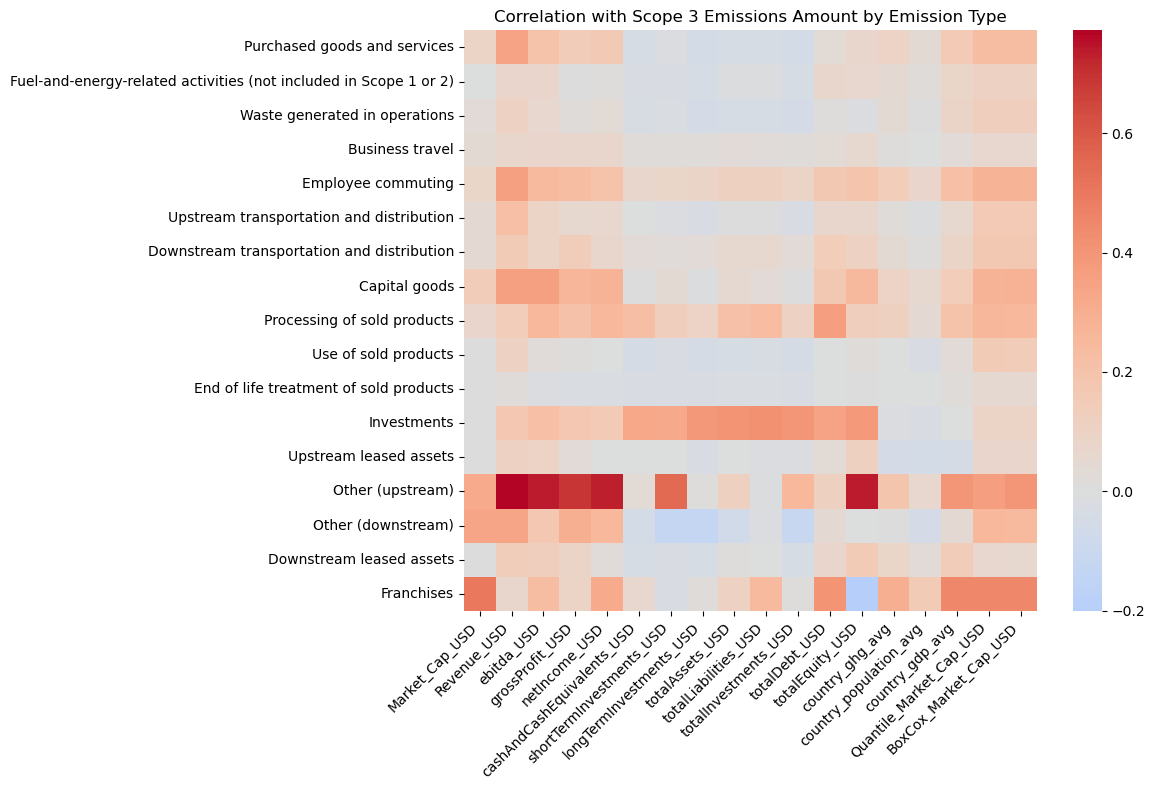

In [17]:
# Calculate correlations for each Scope 3  emissions type
correlations = []
emission_types = df['Scope_3_emissions_type'].unique()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols[numerical_cols != 'Scope_3_emissions_amount'] 
numerical_cols = numerical_cols[numerical_cols != 'Year'] 
numerical_cols = numerical_cols[numerical_cols != 'account_id'] 

for emission_type in emission_types:
    subset = df[df['Scope_3_emissions_type'] == emission_type]
    corr = subset[numerical_cols].corrwith(subset['Scope_3_emissions_amount'])
    correlations.append(corr)

# Create DataFrame with correlations
corr_df = pd.DataFrame(correlations, index=emission_types)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, cmap='coolwarm', center=0)
plt.title('Correlation with Scope 3 Emissions Amount by Emission Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### *List correlations that are over .4*

In [19]:
# Initialize empty list before the loop
correlations = []  # Added this line to ensure clean start

for emission_type in emission_types:
    subset = df[df['Scope_3_emissions_type'] == emission_type]
    # Calculate correlation for this specific emission type
    corr = subset[numerical_cols].corrwith(subset['Scope_3_emissions_amount'])
    # Append as a single row
    correlations.append(corr)

# Create DataFrame with correlations - ensure index and data match
corr_df = pd.DataFrame(correlations, index=emission_types, columns=numerical_cols)  # Added columns parameter

# Find correlations over 0.4
high_correlations = []
for emission_type in emission_types:
    for column in numerical_cols:
        correlation = corr_df.loc[emission_type, column]
        if abs(correlation) > 0.4:
            high_correlations.append({
                'Emission Type': emission_type,
                'Feature': column,
                'Correlation': correlation
            })

# Convert to DataFrame and sort by absolute correlation
high_corr_df = pd.DataFrame(high_correlations)
high_corr_df = high_corr_df.sort_values(by='Correlation', key=abs, ascending=False)
print(high_corr_df)

       Emission Type                   Feature  Correlation
3   Other (upstream)               Revenue_USD     0.772232
8   Other (upstream)           totalEquity_USD     0.737589
4   Other (upstream)                ebitda_USD     0.736733
6   Other (upstream)             netIncome_USD     0.730760
5   Other (upstream)           grossProfit_USD     0.685014
7   Other (upstream)  shortTermInvestments_USD     0.550415
11        Franchises            Market_Cap_USD     0.500364
13        Franchises           country_gdp_avg     0.452332
15        Franchises     BoxCox_Market_Cap_USD     0.451525
14        Franchises   Quantile_Market_Cap_USD     0.450599
1        Investments      totalLiabilities_USD     0.420045
0        Investments           totalAssets_USD     0.410385
12        Franchises             totalDebt_USD     0.404935
9   Other (upstream)           country_gdp_avg     0.403445
2        Investments      totalInvestments_USD     0.400177
10  Other (upstream)     BoxCox_Market_C

#### *Bar Plot for Correlation Over .2*

##### Result
Looking at the correlation for emission types, there is some correlation to the features for specific categories. Next, I will also encode the categorical columns and check the correlation.

## Feature Engineering and Modeling

Most Machine Learning models require data encoding for categorical values. There are 2 main encoding methods used:
1. Label encoding
2. One hot encoding

Label encoding assigns a numerical value to every value in a categorical column. This method essentially converts a unique string into a unique number. This route can be problematic to the algorithm if the model assigns value to the numbers beyond categorical limitation. For instance, primary activity has over 50 values. It's safe to assume the model might interpret a value of 1 differently than a value of 50. 

One hot encoding converts every categorical value in each column to a binary value. For machine learning, this is the more ideal option, as it allows every category to be represented by its own binary feature. This prevents the model from assuming an ordinal relationship or ranking  between categories, which can cause inaccurate predictions. Because this dataset includes categorical columns wih many categories, one hot encoding will result in hundreds of features in order to capture every possible categorical value. This will likey result in overly high dimensionality and accumulated feature noise with very little correlation for reliable predictions.

Before deciding which columns to keep for training, I want to encode the categorical features and analyze for any possible correlation.

#### *Label Encode Third Party Verification and Examine Correlation*

In [33]:
# Create a copy of the Third_party_verification column
df['Third_party_verification_encoded'] = df['Third_party_verification'].copy()

# Label encode the column
le = LabelEncoder()
df['Third_party_verification_encoded'] = le.fit_transform(df['Third_party_verification_encoded'])

# Define the emission columns
emission_cols = ['Scope_3_emissions_amount']

# Calculate correlations
correlations = df[emission_cols].corrwith(df['Third_party_verification_encoded'])

# Print detailed information
print("=== Label Encoding Reference ===")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

print("\n=== Correlation Values ===")
for col in emission_cols:
    print(f"{col}: {correlations[col]:.4f}")

# Print value counts of original and encoded values
print("\n=== Value Counts ===")
print("Original Values:")
print(df['Third_party_verification'].value_counts())
print("\nEncoded Values:")
print(df['Third_party_verification_encoded'].value_counts())

=== Label Encoding Reference ===
No emissions data provided: 0
No third-party verification or assurance: 1
Question not applicable: 2
Third-party verification or assurance process in place: 3
nan: 4

=== Correlation Values ===
Scope_3_emissions_amount: 0.0142

=== Value Counts ===
Original Values:
Third_party_verification
Third-party verification or assurance process in place    30103
No third-party verification or assurance                   7196
No emissions data provided                                  253
Question not applicable                                      15
Name: count, dtype: int64

Encoded Values:
Third_party_verification_encoded
3    30103
1     7196
0      253
4       24
2       15
Name: count, dtype: int64


#### *One Hot Encode Primary Sector, Examine Correlation, and add to DataFrame*

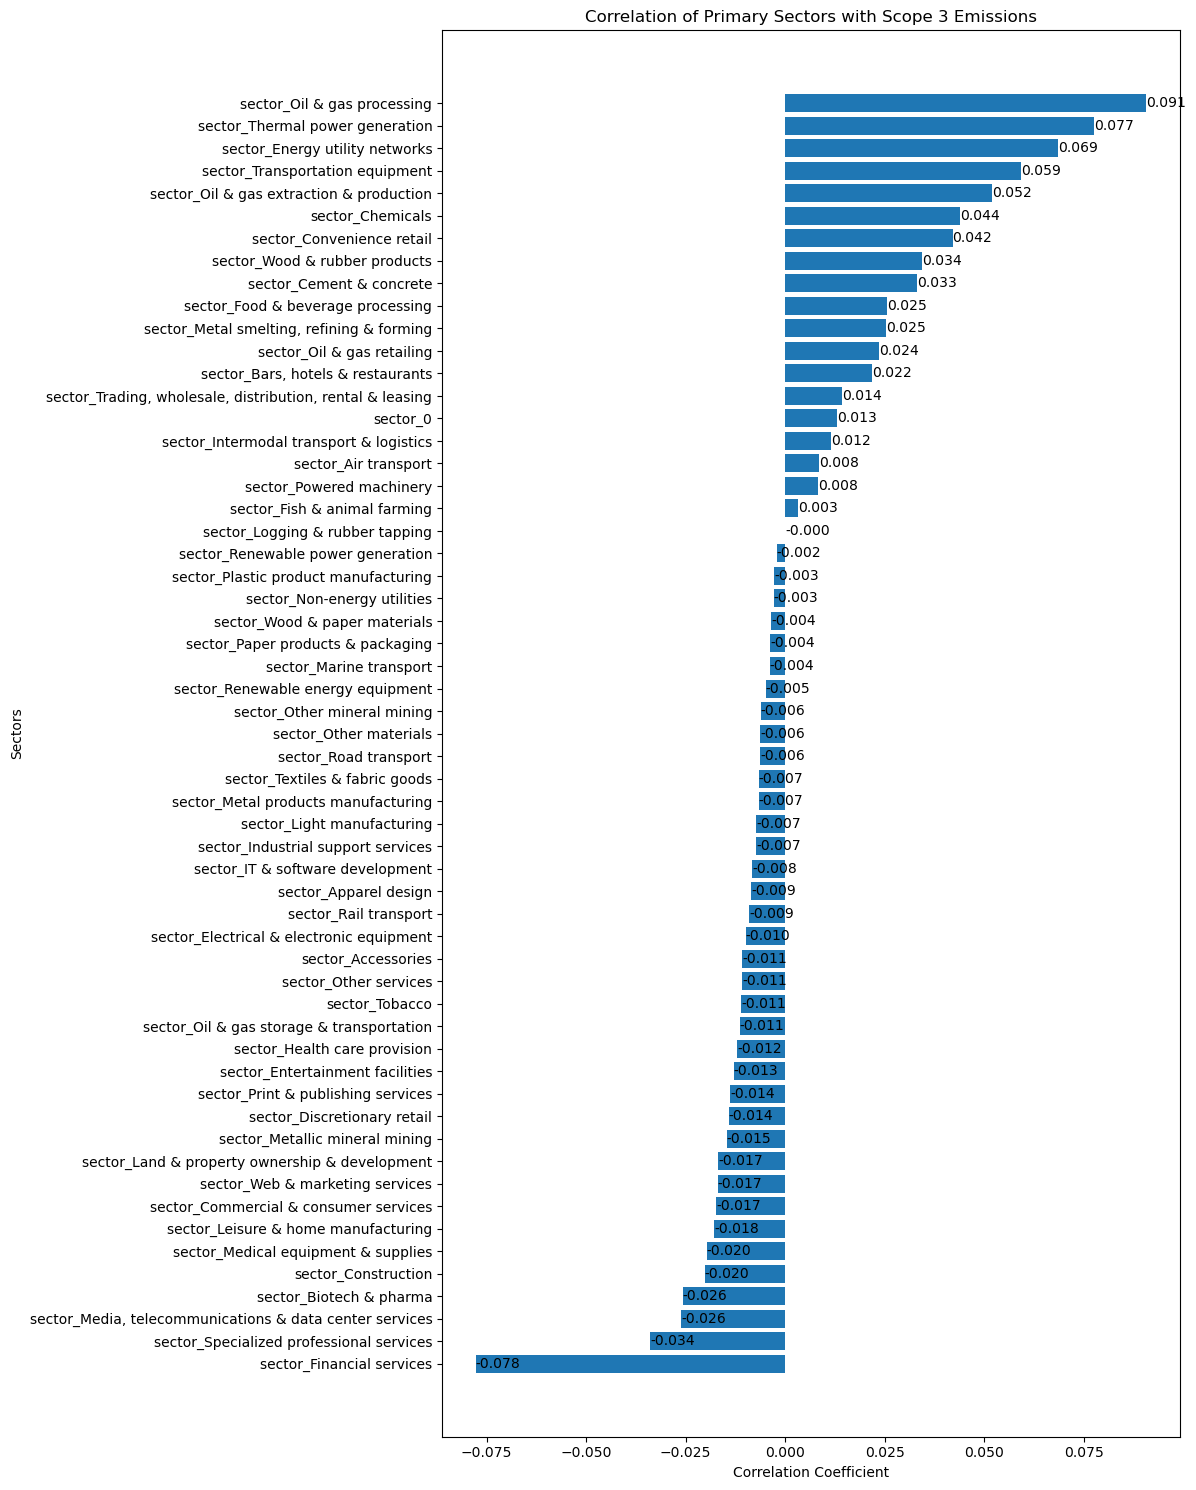


New dataframe shape: (37591, 199)

New columns added:
['sector_0', 'sector_Accessories', 'sector_Air transport', 'sector_Apparel design', 'sector_Bars, hotels & restaurants', 'sector_Biotech & pharma', 'sector_Cement & concrete', 'sector_Chemicals', 'sector_Commercial & consumer services', 'sector_Construction', 'sector_Convenience retail', 'sector_Discretionary retail', 'sector_Electrical & electronic equipment', 'sector_Energy utility networks', 'sector_Entertainment facilities', 'sector_Financial services', 'sector_Fish & animal farming', 'sector_Food & beverage processing', 'sector_Health care provision', 'sector_IT & software development', 'sector_Industrial support services', 'sector_Intermodal transport & logistics', 'sector_Land & property ownership & development', 'sector_Leisure & home manufacturing', 'sector_Light manufacturing', 'sector_Logging & rubber tapping', 'sector_Marine transport', 'sector_Media, telecommunications & data center services', 'sector_Medical equipment

In [51]:
# One-hot encode Primary Sector
sector_dummies = pd.get_dummies(df['Primary sector'], prefix='sector')

# Calculate correlations with Scope_3_emissions_amount
sector_correlations = sector_dummies.apply(lambda x: x.corr(df['Scope_3_emissions_amount']))

# Sort correlations and create bar plot
plt.figure(figsize=(12, 15))
sector_correlations_sorted = sector_correlations.sort_values()

# Barh plot
plt.barh(  
    y=range(len(sector_correlations_sorted)),
    width=sector_correlations_sorted.values
)
plt.yticks(range(len(sector_correlations_sorted)), sector_correlations_sorted.index)

plt.title('Correlation of Primary Sectors with Scope 3 Emissions')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Sectors')

# Add value labels
for i, v in enumerate(sector_correlations_sorted.values):
    plt.text(v, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Append one-hot encoded columns to original dataframe
df = pd.concat([df, sector_dummies], axis=1)

# Show the shape of the new dataframe
print(f"\nNew dataframe shape: {df.shape}")
print("\nNew columns added:")
print(list(sector_dummies.columns))

#### *One Hot Encode Primary Activity, Examine Correlation, and Add to DataFrame*

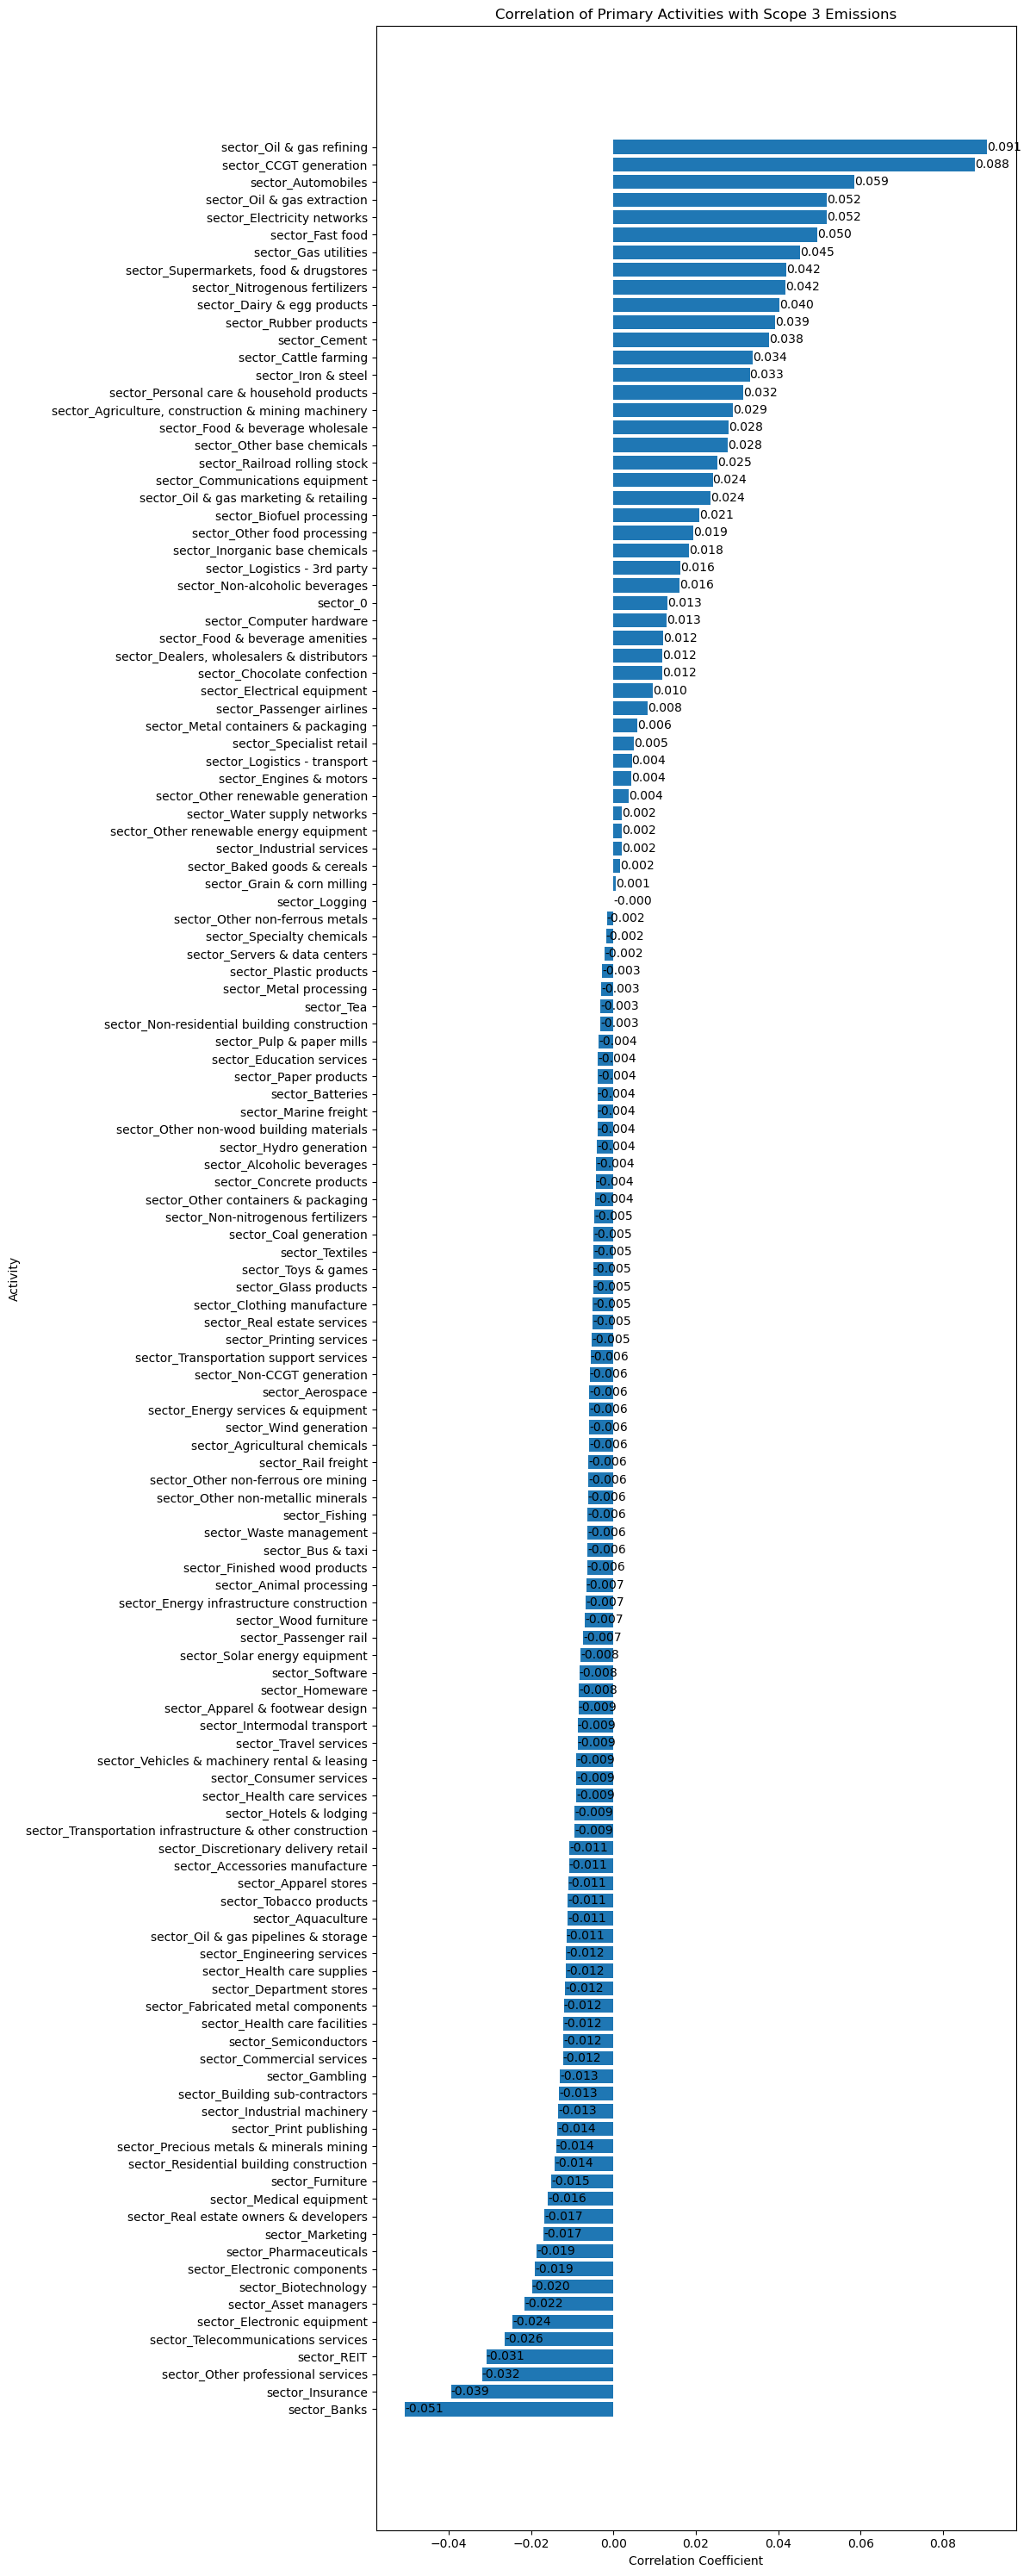


New dataframe shape: (37591, 459)

New columns added:
['sector_0', 'sector_Accessories manufacture', 'sector_Aerospace', 'sector_Agricultural chemicals', 'sector_Agriculture, construction & mining machinery', 'sector_Alcoholic beverages', 'sector_Animal processing', 'sector_Apparel & footwear design', 'sector_Apparel stores', 'sector_Aquaculture', 'sector_Asset managers', 'sector_Automobiles', 'sector_Baked goods & cereals', 'sector_Banks', 'sector_Batteries', 'sector_Biofuel processing', 'sector_Biotechnology', 'sector_Building sub-contractors', 'sector_Bus & taxi', 'sector_CCGT generation', 'sector_Cattle farming', 'sector_Cement', 'sector_Chocolate confection', 'sector_Clothing manufacture', 'sector_Coal generation', 'sector_Commercial services', 'sector_Communications equipment', 'sector_Computer hardware', 'sector_Concrete products', 'sector_Consumer services', 'sector_Dairy & egg products', 'sector_Dealers, wholesalers & distributors', 'sector_Department stores', 'sector_Discret

In [56]:
# One-hot encode Primary Activity
sector_dummies = pd.get_dummies(df['Primary activity'], prefix='sector')

# Calculate correlations with Scope_3_emissions_amount
sector_correlations = sector_dummies.apply(lambda x: x.corr(df['Scope_3_emissions_amount']))

# Sort correlations and create bar plot
plt.figure(figsize=(12, 30))
sector_correlations_sorted = sector_correlations.sort_values()

# Barh plot
plt.barh(  
    y=range(len(sector_correlations_sorted)),
    width=sector_correlations_sorted.values
)
plt.yticks(range(len(sector_correlations_sorted)), sector_correlations_sorted.index)

plt.title('Correlation of Primary Activities with Scope 3 Emissions')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Activity')

# Add value labels
for i, v in enumerate(sector_correlations_sorted.values):
    plt.text(v, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Append one-hot encoded columns to original dataframe
df = pd.concat([df, sector_dummies], axis=1)

# Show the shape of the new dataframe
print(f"\nNew dataframe shape: {df.shape}")
print("\nNew columns added:")
print(list(sector_dummies.columns))

#### Drop original categorical columns and features with no correlation

In [61]:
drop_columns = [   'Market_Cap_USD'
                   ,'cashAndCashEquivalents_USD'
                   ,'totalInvestments_USD'
                   ,'totalAssets_USD'
                   ,'totalLiabilities_USD'
                   ,'Third_party_verification'
                   ,'Primary sector'
                   ,'Primary activity'
                   ,'incorporated_country'
                   ,'account_name'
                   ]
df = df.drop(columns=drop_columns)
df.describe()

account_id          Year   Revenue_USD    ebitda_USD  \
count  37591.000000  37591.000000  3.721600e+04  3.721600e+04   
mean   16284.086217   2020.695831  1.565428e+10  3.202326e+09   
std    13768.930851      1.705508  2.690095e+10  7.425178e+09   
min       44.000000   2018.000000 -1.711368e+10 -9.289400e+10   
25%     6907.000000   2019.000000  3.101446e+09  4.189952e+08   
50%    13604.000000   2021.000000  7.719840e+09  1.154142e+09   
75%    20363.000000   2022.000000  1.722000e+10  2.992461e+09   
max    74137.000000   2023.000000  3.943280e+11  1.305410e+11   

       grossProfit_USD  netIncome_USD  shortTermInvestments_USD  \
count     3.721600e+04   3.721600e+04              3.721600e+04   
mean      7.204884e+09   1.550169e+09              3.723907e+09   
std       1.463569e+10   4.910039e+09              2.995586e+10   
min      -2.699258e+10  -1.680588e+10             -1.414534e+12   
25%       9.327808e+08   1.229696e+08              0.000000e+00   
50%       2.418867e+09   4.571904e+08              1.517440e+07   
75%       6.455447e+09   1.314000e+09              2.685632e+08   
max       1.740620e+11   9.980300e+10              4.505814e+11   

       longTermInvestments_USD  totalDebt_USD  totalEquity_USD  \
count             3.721600e+04   3.721600e+04     3.721600e+04   
mean              1.348675e+10   1.213178e+10     1.148517e+10   
std               6.761988e+10   3.462092e+10     2.288397e+10   
min              -1.626800e+10   0.000000e+00    -1.073900e+10   
25%               6.070600e+07   9.741696e+08     1.855788e+09   
50%               4.081728e+08   3.266440e+09     4.521462e+09   
75%               1.938586e+09   9.434441e+09     1.119881e+10   
max               1.229707e+12   7.756765e+11     3.278780e+11   

       Scope_3_emissions_amount  country_ghg_avg  country_population_avg  \
count              3.759100e+04     37540.000000            3.759100e+04   
mean               8.116580e+05      2076.109243            1.774763e+08   
std                3.455711e+06      2666.200431            2.493810e+08   
min                2.000000e-03         9.384733            6.453412e+04   
25%                2.962790e+03       428.766726            5.936228e+07   
50%                2.181470e+04      1173.044363            1.258077e+08   
75%                1.822935e+05      5260.920557            3.315243e+08   
max                5.199799e+07     13105.528962            1.410932e+09   

       country_gdp_avg  Quantile_Market_Cap_USD  BoxCox_Market_Cap_USD  \
count     3.759100e+04             37591.000000           37591.000000   
mean      8.010937e+12                -0.001176              18.405299   
std       9.006676e+12                 1.008267               1.040131   
min       7.583005e+09                -5.199338              12.769209   
25%       1.705162e+12                -0.685031              17.703800   
50%       4.772504e+12                 0.008782              18.375093   
75%       1.632198e+13                 0.673936              19.092849   
max       2.383859e+13                 5.199338              22.348342   

       Third_party_verification_encoded  
count                      37591.000000  
mean                           2.597191  
std                            0.815529  
min                            0.000000  
25%                            3.000000  
50%                            3.000000  
75%                            3.000000  
max                            4.000000

### Remove NULLS
Now that the features have been finalized, I will remove any account that has a null observation. It is possible to utilize the null parameter in XGBoost and the imputer in Random Forest, but as a start, I want a clean and consistent dataset for these intial models to build from. 

In [63]:
# Create a summary dataframe to analyze nulls
summary_df = pd.DataFrame({
    'Data_Type': df.dtypes,
    'Null_Count': df.isnull().sum(),
    'Null_Percentage': (df.isnull().sum() / len(df) * 100).round(2),})

print("\nDataFrame Summary:")
print(summary_df)

# Print total null count
print("\nTotal null values in DataFrame:", df.isnull().sum().sum())

# How many accounts have at least 1 null value?
null_accounts = df[df.isnull().any(axis=1)]['account_id'].nunique()
print(f"Number of accounts with at least one null value: {null_accounts}")


DataFrame Summary:
                                             Data_Type  Null_Count  \
account_id                                       int64           0   
Year                                             int64           0   
Revenue_USD                                    float64         375   
ebitda_USD                                     float64         375   
grossProfit_USD                                float64         375   
...                                                ...         ...   
sector_Vehicles & machinery rental & leasing      bool           0   
sector_Waste management                           bool           0   
sector_Water supply networks                      bool           0   
sector_Wind generation                            bool           0   
sector_Wood furniture                             bool           0   

                                              Null_Percentage  
account_id                                                0.0  
Year       

#### *Remove Accounts with at least one NULL observation*

In [66]:
# Get initial unique account count
initial_accounts = df['account_id'].nunique()
initial_account_list = set(df['account_id'].unique())

# Remove rows with any null values
df_clean = df.dropna(axis=0, how='any')

# Get final unique account count
final_accounts = df_clean['account_id'].nunique()
final_account_list = set(df_clean['account_id'].unique())

# Calculate removed accounts
removed_accounts = initial_account_list - final_account_list

# Print summary statistics
print(f"Initial number of unique accounts: {initial_accounts}")
print(f"Final number of unique accounts: {final_accounts}")
print(f"Number of unique accounts removed: {len(removed_accounts)}")
print(f"Percentage of unique accounts removed: {(len(removed_accounts) / initial_accounts * 100):.2f}%")

# Verify no null values remain
print("\nVerifying no null values remain:")
null_check = df_clean.isnull().sum()
print(null_check[null_check > 0] if len(null_check[null_check > 0]) > 0 else "No null values remaining")

Initial number of unique accounts: 966
Final number of unique accounts: 957
Number of unique accounts removed: 9
Percentage of unique accounts removed: 0.93%

Sample of 5 removed account_ids (if any):
[31426, 20301, 22768, 13520, 10162]

Verifying no null values remain:
No null values remaining


In [68]:
# Reassign to original dataframe
df = df_clean

# Create a point in time of this original dataframe
df_original = df

# Machine Learning
I believe the models that best suit the nature of this data include:
#### 1. **XGBoost**
#### 2. **Random Forest**

Both models work well for the follwing reasons:

- Both are able to handle complex data relationships, which is a characteristic of Scope 3 emissions data.
- Able to capture non-linear relationships and interactions between variables.
- Robust to outliers, which common in emissions data and are less prone to overfitting.
- Work well with mixed data types (numerical and categorical), which is common in emissions reporting.
- Feature Importance: Both provide clear insights into which factors most influence emissions and can help identify key areas for emissions reduction.
- Scope 3 data frequently has gaps due to reporting challenges. While missing data was removed from the final dataset, it would be worthwhile to also test the models without data removal and compare the results as both models do well with handling missing values.
    - Random Forest can operate with missing data without imputation
    - XGBoost has built-in methods for missing value handling

##### **Model Design**
The algorithms will train on a time-series of all previous years in conjunction with numerical features in order to predict the most recent observation (Year 2023) within each Emission type.

##### **MAE (Mean Absolute Error)**
Performance will be analyzed using MAE. MAE measures the average magnitude of errors between predicted and actual values, without considering their direction (high or low). It is best in this prediction scenario because:

- The absolute scale of errors matters, as the absolute difference between actual and predicted emission amounts is highly important.
- MAE is in the same unit as the emission amount and both over and under-predictions are equally important.
- Direct, interpretable results and error measurements are needed in this scenario (MAE is more interpretable than percentage-based errors).
- Outliers exist but shouldn't dominate the error metric (MAE is more robust to outliers than squared metrics, such as MSE and RMSE).

### XGBoost

#### *Build the Model*

In [212]:
# Create empty lists to store results
mae_scores = []
emission_types = []
max_year_actuals = []
max_year_predictions = []

# Define numerical columns and gather features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
feature_cols = [col for col in numerical_cols 
               if col not in ['Scope_3_emissions_amount', 'Year']]
selected_features = ['Year'] + feature_cols

# Dictionary to store results for each emission type
results_dict = {}

# Loop through each unique emission type
for emission_type in df['Scope_3_emissions_type'].unique():
    # Filter data for current emission type
    type_df = df[df['Scope_3_emissions_type'] == emission_type].copy()
    
    # Get the maximum year for this emission type
    max_year = type_df['Year'].max()
    
    # Split into train and test
    train_df = type_df[type_df['Year'] < max_year].copy()
    test_df = type_df[type_df['Year'] == max_year].copy()
    
    if len(train_df) == 0 or len(test_df) == 0:
        continue
        
    # Prepare features and target for training
    X_train = train_df[selected_features]
    y_train = train_df['Scope_3_emissions_amount']
    
    # Prepare features and target for testing
    X_test = test_df[selected_features]
    y_test = test_df['Scope_3_emissions_amount']
    
    # Train XGBoost model
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    
    # Store results
    results_dict[emission_type] = {
        'mae': mae,
        'actuals': y_test.values.tolist(),
        'predictions': predictions.tolist()
    }

#### *Feature Importance*

In [214]:
# Feature importance analysis
xgb_feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
    
results_dict[emission_type]['feature_importance'] = xgb_feature_importance

xgb_feature_importance

feature  importance
9                    totalEquity_USD        0.72
13           Quantile_Market_Cap_USD        0.15
4                    grossProfit_USD        0.06
1                         account_id        0.02
2                        Revenue_USD        0.01
8                      totalDebt_USD        0.01
3                         ebitda_USD        0.00
11            country_population_avg        0.00
12                   country_gdp_avg        0.00
10                   country_ghg_avg        0.00
7            longTermInvestments_USD        0.00
0                               Year        0.00
6           shortTermInvestments_USD        0.00
5                      netIncome_USD        0.00
15  Third_party_verification_encoded        0.00
14             BoxCox_Market_Cap_USD        0.00

#### *Vizualize Results*

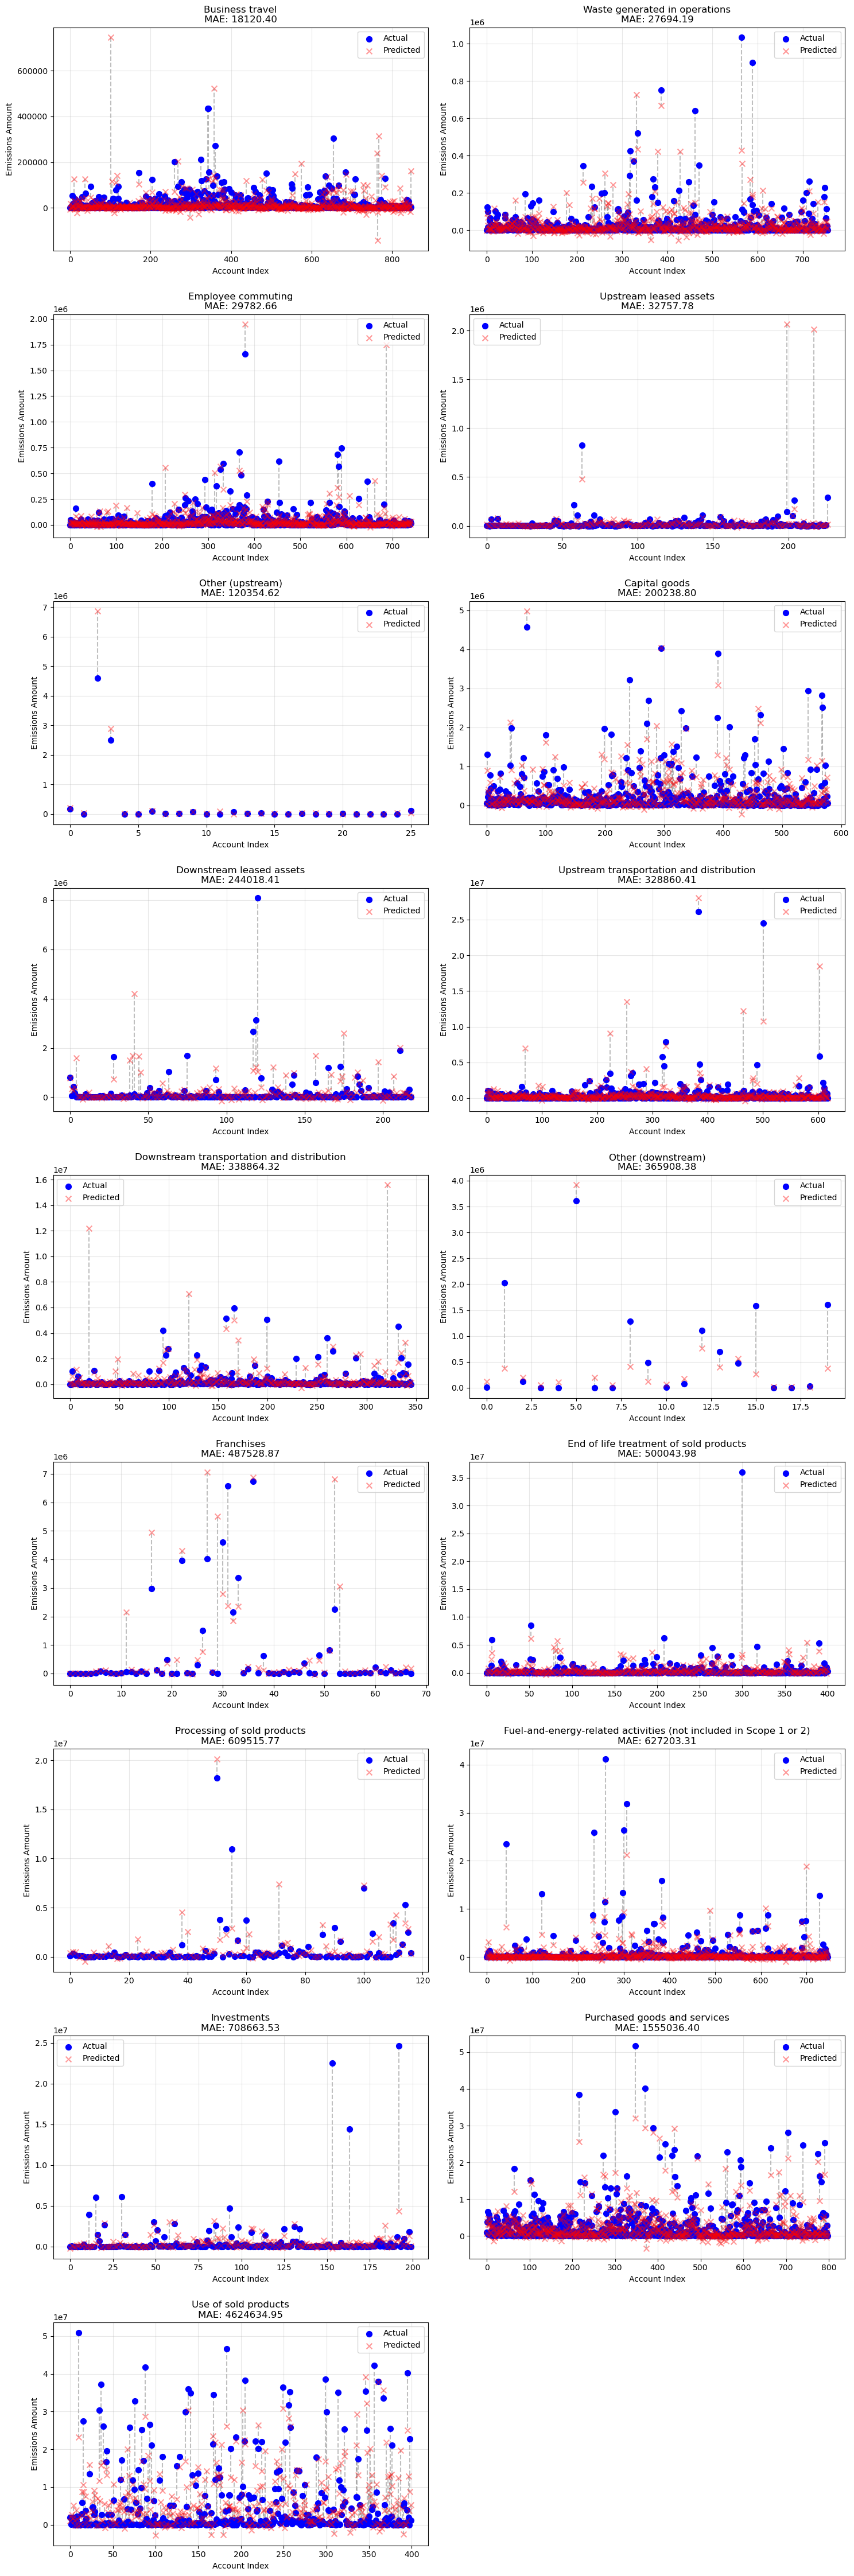

In [216]:
# Sort emission types by MAE
sorted_types = sorted(results_dict.items(), key=lambda x: x[1]['mae'])

# Create subplots based on number of valid emission types
n_types = len(sorted_types)
if n_types > 0:
    n_cols = 2
    n_rows = math.ceil(n_types / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axs = axs.flatten() if n_rows > 1 else [axs]

    # Plot results
    for idx, (emission_type, results) in enumerate(sorted_types):
        actuals = results['actuals']
        predictions = results['predictions']
        mae = results['mae']
        
        # Draw lines connecting actual to predicted values
        for i in range(len(actuals)):
            axs[idx].plot([i, i], [actuals[i], predictions[i]], 'gray', linestyle='--', alpha=0.5, zorder=1)
        
        # Create scatter plot for actuals (solid blue, behind predictions)
        axs[idx].scatter(range(len(actuals)), actuals, color='blue', label='Actual', 
                        zorder=2, s=50, alpha=1.0)
        # Create scatter plot for predictions (x marker, semi-transparent, in front)
        axs[idx].scatter(range(len(predictions)), predictions, color='red', marker='x', label='Predicted', 
                        zorder=3, s=50, alpha=0.4)
        axs[idx].set_title(f'{emission_type}\nMAE: {mae:.2f}')
        axs[idx].set_xlabel('Account Index')
        axs[idx].set_ylabel('Emissions Amount')
        axs[idx].legend()
        axs[idx].grid(True, alpha=0.3)

    # Remove empty subplots if any
    for idx in range(len(sorted_types), len(axs)):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.show()

    # Store MAE scores
    xgb_results = pd.DataFrame([
        {'Emission_Type': et, 'MAE_Score': res['mae']} 
        for et, res in sorted_types
    ])

else:
    print("No valid data to plot")

#### *Compare MAE Metric to Standard Deviation*

In [221]:
# Results analysis
if n_types > 0:
    plt.tight_layout()
    plt.show()

    # Create comprehensive results dataframe
    results_list = []
    for emission_type, results in sorted_types:
        actuals = results['actuals']
        mae = results['mae']
        std = np.std(actuals)
        mean = np.mean(actuals)
        
        results_list.append({
            'Emission_Type': emission_type,
            'MAE_Score': mae,
            'Standard_Deviation': std,
            'Mean': mean,
            'MAE/STD': (mae / std),
            'MAE/Mean': (mae / mean) if mean != 0 else np.inf
        })

    xgb_results = pd.DataFrame(results_list)
    
    # Format the results
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print("\nXGBoost Results Analysis:")

    print("\nSummary Statistics:")
    print(f"Average MAE/STD: {xgb_results['MAE/STD'].mean():.2f}")
    print(f"Average MAE/Mean: {xgb_results['MAE/Mean'].mean():.2f}")   
    
    print("\nDetailed Metrics for Each Emission Type:")
    print(xgb_results.to_string(index=False)) 

else:
    print("No valid data to plot")

<Figure size 640x480 with 0 Axes>


XGBoost Results Analysis:

Summary Statistics:
Average MAE/STD: 0.34
Average MAE/Mean: 0.94

Detailed Metrics for Each Emission Type:
                                                    Emission_Type  MAE_Score  Standard_Deviation       Mean  MAE/STD  MAE/Mean
                                                  Business travel   18120.40            35292.54   15760.04     0.51      1.15
                                    Waste generated in operations   27694.19            78557.48   26723.97     0.35      1.04
                                               Employee commuting   29782.66           100089.82   38113.19     0.30      0.78
                                           Upstream leased assets   32757.78            64805.91   20308.79     0.51      1.61
                                                 Other (upstream)  120354.62           982396.17  295763.92     0.12      0.41
                                                    Capital goods  200238.80           527242.80  27117

## Random Forest

#### *Build the Model*

In [185]:
# Create empty lists to store results
mae_scores = []
emission_types = []
max_year_actuals = []
max_year_predictions = []

# Define numerical columns and gather features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
feature_cols = [col for col in numerical_cols 
               if col not in ['Scope_3_emissions_amount', 'Year']]
selected_features = ['Year'] + feature_cols

# Dictionary to store results for each emission type
results_dict = {}

# Loop through each unique emission type
for emission_type in df['Scope_3_emissions_type'].unique():
    # Filter data for current emission type
    type_df = df[df['Scope_3_emissions_type'] == emission_type].copy()
    
    # Get the maximum year for this emission type
    max_year = type_df['Year'].max()
    
    # Split into train and test
    train_df = type_df[type_df['Year'] < max_year].copy()
    test_df = type_df[type_df['Year'] == max_year].copy()
    
    if len(train_df) == 0 or len(test_df) == 0:
        continue
        
    # Prepare features and target for training
    X_train = train_df[selected_features]
    y_train = train_df['Scope_3_emissions_amount']
    
    # Prepare features and target for testing
    X_test = test_df[selected_features]
    y_test = test_df['Scope_3_emissions_amount']
    
    # Train Random Forest model
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    
    # Store results
    results_dict[emission_type] = {
        'mae': mae,
        'actuals': y_test.values.tolist(),
        'predictions': predictions.tolist()
    }

#### *Feature Importance*

In [187]:
# Feature importance analysis
rf_feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
    
results_dict[emission_type]['feature_importance'] = rf_feature_importance

rf_feature_importance

feature  importance
9                    totalEquity_USD        0.69
13           Quantile_Market_Cap_USD        0.08
14             BoxCox_Market_Cap_USD        0.07
4                    grossProfit_USD        0.04
6           shortTermInvestments_USD        0.03
1                         account_id        0.02
8                      totalDebt_USD        0.01
2                        Revenue_USD        0.01
7            longTermInvestments_USD        0.01
0                               Year        0.01
3                         ebitda_USD        0.01
5                      netIncome_USD        0.01
12                   country_gdp_avg        0.00
11            country_population_avg        0.00
10                   country_ghg_avg        0.00
15  Third_party_verification_encoded        0.00

#### *Vizualize Results*

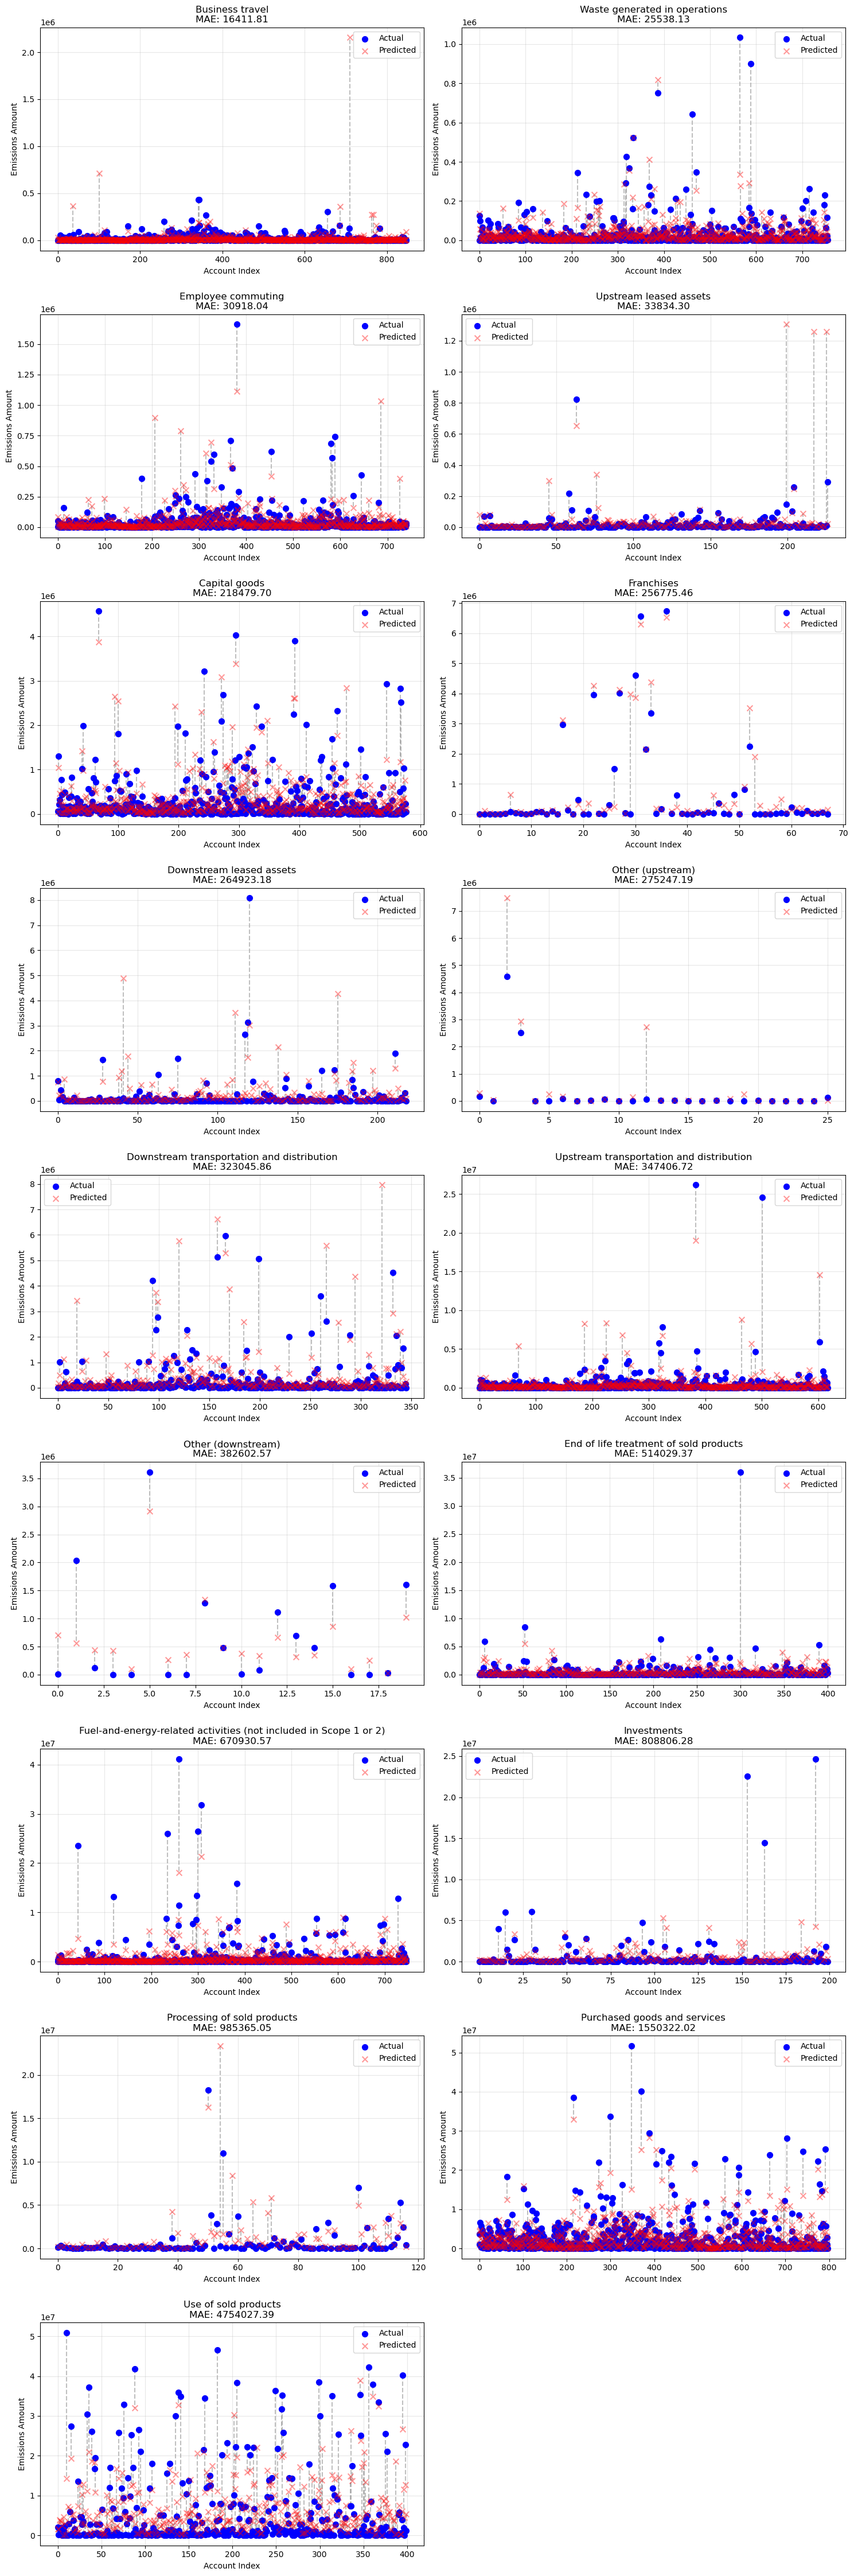

In [189]:
# Sort emission types by MAE
sorted_types = sorted(results_dict.items(), key=lambda x: x[1]['mae'])

# Create subplots based on number of valid emission types
n_types = len(sorted_types)
if n_types > 0:
    n_cols = 2
    n_rows = math.ceil(n_types / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axs = axs.flatten() if n_rows > 1 else [axs]

    # Plot results
    for idx, (emission_type, results) in enumerate(sorted_types):
        actuals = results['actuals']
        predictions = results['predictions']
        mae = results['mae']
        
        # Draw lines connecting actual to predicted values
        for i in range(len(actuals)):
            axs[idx].plot([i, i], [actuals[i], predictions[i]], 'gray', linestyle='--', alpha=0.5, zorder=1)
        
        # Create scatter plot for actuals (solid blue, behind predictions)
        axs[idx].scatter(range(len(actuals)), actuals, color='blue', label='Actual', 
                        zorder=2, s=50, alpha=1.0)
        # Create scatter plot for predictions (x marker, semi-transparent, in front)
        axs[idx].scatter(range(len(predictions)), predictions, color='red', marker='x', label='Predicted', 
                        zorder=3, s=50, alpha=0.4)
        axs[idx].set_title(f'{emission_type}\nMAE: {mae:.2f}')
        axs[idx].set_xlabel('Account Index')
        axs[idx].set_ylabel('Emissions Amount')
        axs[idx].legend()
        axs[idx].grid(True, alpha=0.3)

    # Remove empty subplots if any
    for idx in range(len(sorted_types), len(axs)):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.show()

    # Store MAE scores
    rf_results = pd.DataFrame([
        {'Emission_Type': et, 'MAE_Score': res['mae']} 
        for et, res in sorted_types
    ])

else:
    print("No valid data to plot")

#### *Compare MAE Metric to Standard Deviation*

In [209]:
# Results analysis
if n_types > 0:
    plt.tight_layout()
    plt.show()

    # Create comprehensive results dataframe
    results_list = []
    for emission_type, results in sorted_types:
        actuals = results['actuals']
        mae = results['mae']
        std = np.std(actuals)
        mean = np.mean(actuals)
        
        results_list.append({
            'Emission_Type': emission_type,
            'MAE_Score': mae,
            'Standard_Deviation': std,
            'Mean': mean,
            'MAE/STD': (mae / std),
            'MAE/Mean': (mae / mean) if mean != 0 else np.inf
        })

    rf_results = pd.DataFrame(results_list)
    
    # Format the results
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print("\nRandom Forest Results Analysis:")

    print("\nSummary Statistics:")
    print(f"Average MAE/STD: {rf_results['MAE/STD'].mean():.2f}")
    print(f"Average MAE/Mean: {rf_results['MAE/Mean'].mean():.2f}")   
    
    print("\nDetailed Metrics for Each Emission Type:")
    print(rf_results.to_string(index=False)) 

else:
    print("No valid data to plot")

<Figure size 640x480 with 0 Axes>


Random Forest Results Analysis:

Summary Statistics:
Average MAE/STD: 0.35
Average MAE/Mean: 1.00

Detailed Metrics for Each Emission Type:
                                                    Emission_Type  MAE_Score  Standard_Deviation       Mean  MAE/STD  MAE/Mean
                                                  Business travel   16411.81            35292.54   15760.04     0.47      1.04
                                    Waste generated in operations   25538.13            78557.48   26723.97     0.33      0.96
                                               Employee commuting   30918.04           100089.82   38113.19     0.31      0.81
                                           Upstream leased assets   33834.30            64805.91   20308.79     0.52      1.67
                                                    Capital goods  218479.70           527242.80  271175.10     0.41      0.81
                                                       Franchises  256775.46          1477851.41 

### Compare XGBoost and Random Forest Models

In [193]:
# Create a comparison dataframe that outer joins the MAE results of each model
comparison_df = pd.merge(
    rf_results.rename(columns={'MAE_Score': 'RF_MAE'}),
    xgb_results.rename(columns={'MAE_Score': 'XGB_MAE'}),
    on='Emission_Type',
    how='outer'
)

# Calculate the difference and percentage difference
comparison_df['MAE_Difference'] = comparison_df['RF_MAE'] - comparison_df['XGB_MAE']
comparison_df['Better_Model'] = comparison_df.apply(
    lambda x: 'Random Forest' if x['RF_MAE'] < x['XGB_MAE'] else 'XGBoost', axis=1
)
comparison_df['Improvement_Percentage'] = abs(comparison_df['MAE_Difference'] / 
    comparison_df[['RF_MAE', 'XGB_MAE']].max(axis=1) * 100)

# Show summary statistics
print("\nOverall Summary:")
print("===============")
print(f"Random Forest better in {(comparison_df['Better_Model'] == 'Random Forest').sum()} cases")
print(f"XGBoost better in {(comparison_df['Better_Model'] == 'XGBoost').sum()} cases")
print(f"Average improvement percentage: {comparison_df['Improvement_Percentage'].mean():.2f}%")

# Format and display results for each emission type
print("\nDetailed Comparison by Emission Type:")
print("====================================")
for _, row in comparison_df.iterrows():
    print(f"\nEmission Type: {row['Emission_Type']}")
    print(f"Better Model: {row['Better_Model']}")
    print(f"Improvement: {row['Improvement_Percentage']:.2f}%")


Overall Summary:
Random Forest better in 5 cases
XGBoost better in 12 cases
Average improvement percentage: 13.00%

Detailed Comparison by Emission Type:

Emission Type: Business travel
Better Model: Random Forest
Improvement: 9.43%

Emission Type: Waste generated in operations
Better Model: Random Forest
Improvement: 7.79%

Emission Type: Employee commuting
Better Model: XGBoost
Improvement: 3.67%

Emission Type: Upstream leased assets
Better Model: XGBoost
Improvement: 3.18%

Emission Type: Capital goods
Better Model: XGBoost
Improvement: 8.35%

Emission Type: Franchises
Better Model: Random Forest
Improvement: 47.33%

Emission Type: Downstream leased assets
Better Model: XGBoost
Improvement: 7.89%

Emission Type: Other (upstream)
Better Model: XGBoost
Improvement: 56.27%

Emission Type: Downstream transportation and distribution
Better Model: Random Forest
Improvement: 4.67%

Emission Type: Upstream transportation and distribution
Better Model: XGBoost
Improvement: 5.34%

Emission 

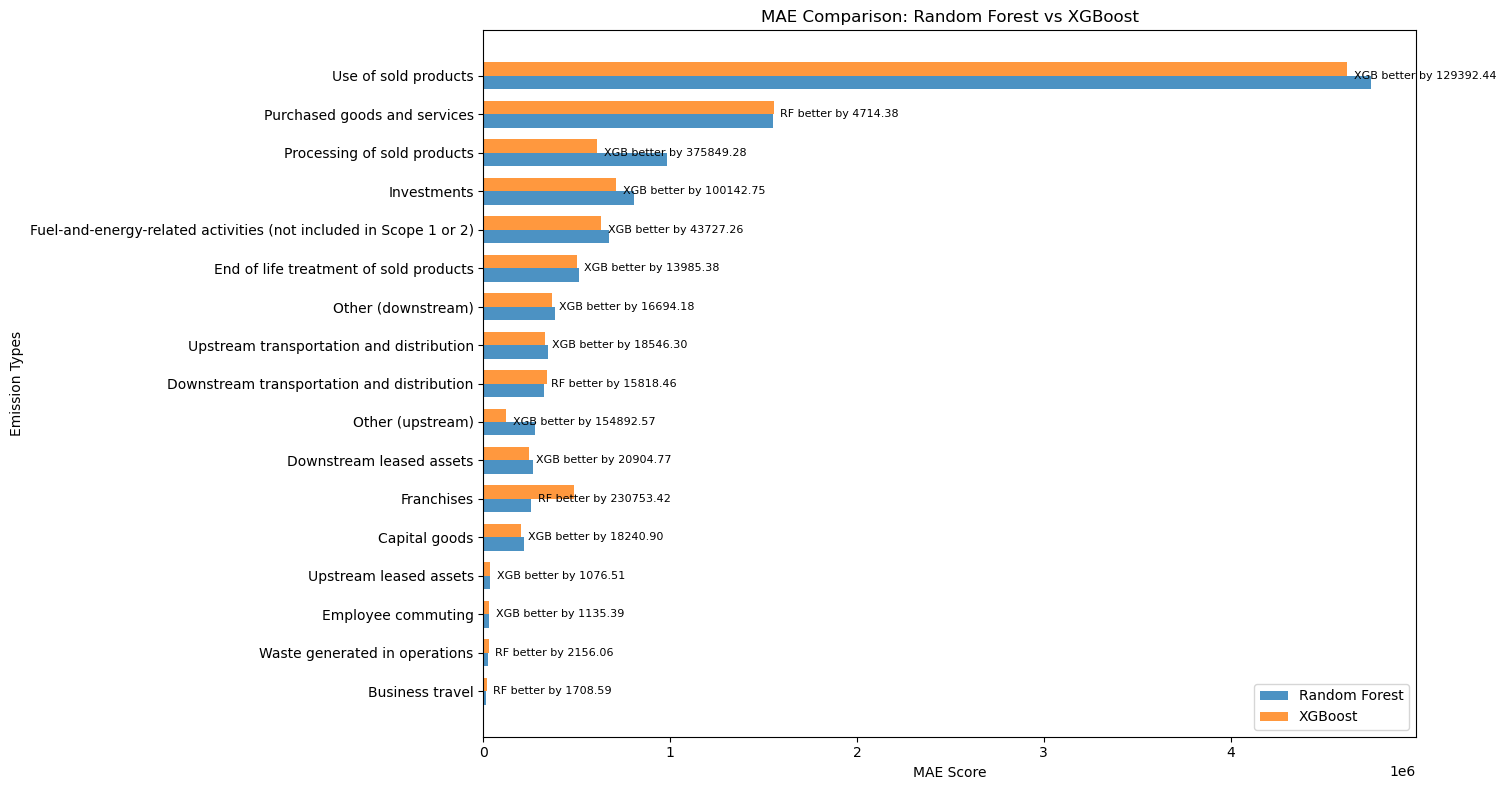

In [163]:
# Vizualize the comparison

plt.figure(figsize=(15, 8))
y = np.arange(len(comparison_df))
height = 0.35

# Create horizontal bars
rf_bars = plt.barh(y - height/2, comparison_df['RF_MAE'], height, label='Random Forest', alpha=0.8)
xgb_bars = plt.barh(y + height/2, comparison_df['XGB_MAE'], height, label='XGBoost', alpha=0.8)

# Add labels showing which model is better and by how much
for idx in range(len(comparison_df)):
    rf_mae = comparison_df['RF_MAE'].iloc[idx]
    xgb_mae = comparison_df['XGB_MAE'].iloc[idx]
    difference = abs(rf_mae - xgb_mae)
    
    if rf_mae < xgb_mae:
        better_model = 'RF better by'
        x_pos = rf_mae
    else:
        better_model = 'XGB better by'
        x_pos = xgb_mae
    
    # Add text label to indicate which performed better and by how much
    plt.text(x_pos, y[idx], 
             f'  {better_model} {difference:.2f}',  # Added space for separation
             va='center',
             ha='left',
             fontsize=8)

plt.ylabel('Emission Types')
plt.xlabel('MAE Score')
plt.title('MAE Comparison: Random Forest vs XGBoost')
plt.yticks(y, comparison_df['Emission_Type'])
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [223]:
# Average MAE Results Side-by-Side

print("\nXGBoost:")
print(f"Average MAE/STD: {xgb_results['MAE/STD'].mean():.2f}")
print(f"Average MAE/Mean: {xgb_results['MAE/Mean'].mean():.2f}")   

print("\nRandom Forest:")
print(f"Average MAE/STD: {rf_results['MAE/STD'].mean():.2f}")
print(f"Average MAE/Mean: {rf_results['MAE/Mean'].mean():.2f}")   


XGBoost:
Average MAE/STD: 0.34
Average MAE/Mean: 0.94

Random Forest:
Average MAE/STD: 0.35
Average MAE/Mean: 1.00


#### **Analyzing MAE and Model Performance**

MAE measures the average magnitude of errors between predicted and actual values. It is measured with the same unit as the target variable (Emissions amount). Standard Deviation (σ) represents the natural variability and spread of the data and is used to indicate how much actual values deviate from the mean. In general, the higher the STD, the harder it is to predict a target. While the STD was dramatically reduced in the previous outlier and normalization process, the STD remained high across emission types and primary activities. The MAE represents the average prediction error with the same unit as the target, which is emissions amount in case. A quick review of the plot outputs allows you to visually see how close each prediction was and the MAE metric for each emissions type is the average of all predictions within that category.

For both models, the MAE is significantly lower than the standard deviation, which indicates pretty decent prediction performance in comparison to natural variation, especially considering the extreme variability of the data and how spread-out it is. It could likely be improved with more outlier removal and normalization since the STD is sensitive to outliers. Unfortunatly, the features didn't offer a lot of strong correlation, so it is likely more the time-series trend that offered the most prediction power, but deeper analysis would help better understand feature correlation and importance for an improved model. 

When looking at the Mean, the larger ratios may indicate poor performance with significant prediction errors relative to the actual values. However, the MAE/Mean can be misleading with highly variable data, especially with extreme spread and large outlier values. It is potentially an unsuitable metric for measuring performance in this scenario.

Comparing XGBoost to Random Forest, XGBoost seems to perform slightly better with an average MAE/STD ratio of .34 and is potentially a better suited model in this specific scenario. The ratios indicate the model has learned meaningful patterns in the data.

**Outcome**:
- The model's predictions are more accurate than what you'd expect from the natural variation in the data
- The model has successfully captured some underlying patterns beyond random variation
- The predictions are more reliable than simply using the mean value
- The model is performing well relative to the inherent variability and spread in the data

#### **Further Research**

1. Benchmarking against XGBoost and Random Forest
2. Enhanced features and validation to predict targets without time series evaluation
3. Continued normalization, skew transformation, and outlier analysis with possible imputation
4. Testing models on nulls and testing ensemble approaches
5. Testing Deep Learning and Neural Networks:
    - More complex pattern recognition (identify noin-linear relationships, adapt to changing patterns)
    - Better time series prediction
    - Better handling of high-dimensional data with automatic feature extraction
    - Better incorporate categorical data like Primary activity or Sector